# Internal performance comparison of GAlibrate's core genetic algorithm implementations

A few years ago, I tested the performance and scaling of [GAlibrate](https://github.com/blakeaw/GAlibrate)'s different implementations in pure Python, Numba, and Cython: [gao_implementation_scaling_comparison.ipynb](https://github.com/blakeaw/galibrate_performance_comparison/blob/master/gao_implementation_scaling_comparison.ipynb). 

In this notebook, we will redo this performance and scaling analysis to see how a recent implementation that ports key functions to Julia using the PyJulia package compares to the Python, Numba, and Cython versions. 

As with the previous analysis, we'll compare how each implementation scales with the number of parameters (or dimensionality), population size, and the number of generations, as well as their relative performance to the pure Python implementation. Note, however, that we are using a different benchmark function this time.

To run this notebook we need to have galibrate installed along with Numba, Cython, Julia, and PyJulia.  You also need pandas, matplotlib, and microbench packages.


------

## Imports and setup

First we'll do all our imports:

In [1]:
# Non-galibrate imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Notebook magic to inline plots
%matplotlib inline

In [61]:
import cython, numba, matplotlib, julia

In [3]:
# galibrate imports
import galibrate
from galibrate import gao
from galibrate.sampled_parameter import SampledParameter

c:\users\bwils\documents\dev_src\personal\galibrate\galibrate\gao.py:13: RuntimeWarning: ------Running GAO with numba optimization.------
  warnings.warn("------Running GAO with numba optimization.------", RuntimeWarning)


In [4]:
#from allversions import *

In [5]:
# Manually import each of the run_gao modules -- normally galibrate does this internally
# and automatically assigns the version based whether Numba and/or Cython are installed.
# Python-only
from galibrate import run_gao_py


In [6]:
# Numba accelerated
from galibrate import run_gao_numba

In [7]:
# Cython accelerated -- uses pyximport
import pyximport; pyximport.install(language_level=3, setup_args={"include_dirs":np.get_include()})
from galibrate import run_gao_cython

In [8]:
%%capture
# Julia accelerated
from galibrate import run_gao_julia

And we'll setup a custom Bench from microbench to capture some key info about the Python version and some of the library versions:

In [9]:
# Setup a microbench for meta data collection
from microbench import MicroBench, MBCondaPackages, MBHostInfo, MBPythonVersion

class GaoBench(MicroBench, MBHostInfo, MBPythonVersion):
    capture_versions = (np, cython, numba, julia)

   

In [10]:
gaobench = GaoBench()

@gaobench
def meta():
    pass
    
meta() 

In [11]:
bench_results = pd.read_json(gaobench.outfile.getvalue(), lines=True)

In [12]:
# Python version
bench_results['python_version'][0]

'3.10.11'

In [13]:
# Here julia is the PyJulia package.
for pack in bench_results['package_versions']:
    print(pack)

{'numpy': '1.23.5', 'cython': '0.29.33', 'numba': '0.56.4', 'julia': '0.6.1'}


Using Julia version 1.9.2

#### OS and hardware

  * Windows 11 - 64-bit operating system, x64-based processor
  * Processor: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz   2.30 GHz
  * RAM: 16.0 GB (15.6 GB usable)

## Model problem and fitness function

For the purposes of this testing, we'll use the N-dimensional sphere function defined in `galibrate.benchmarks` with a parameter search in \[-100:100\].

Here is the fitness function:

In [14]:
from galibrate.benchmarks import sphere

def fitness(chromosome):
    return -sphere(chromosome)

------

## Scaling with the number of parameters (dimensionality)

We'll start by examining the scaling with the number of parameters while holding the population size and number of generations fixed.

In [15]:
# Define the parameters for the GAO.
# Here, we are scaling the number of model parameters or dimensionality.
# We'll consider up to 1000 parameters.
ndims = list([3, 10, 20, 50, 100, 200, 500, 800, 1000])
# We'll fix the population size at 100:
popsize = 100
# And the number of generations also to 100:
generations = 100

In [16]:
def scaling_dimensions(ndims, version=None, popsize=1000, generations=100):
    if version is not None:
        gao.run_gao = version
    timings = dict()
    timings['n_dim'] = list()
    timings['avg_time'] = list()
    timings['std_dev'] = list()
    # Loop over the dimensionality (number of parameters)
    for ndim in ndims:
        print("Doing ndim: ", ndim)
        timings['n_dim'].append(ndim)
        sampled_parameters = [SampledParameter(name=i, loc=-100.0, width=200.0) for i in range(ndim)]
        go = gao.GAO(sampled_parameters, fitness, popsize, generations=generations)
        #print(ndim, popsize, gen)
        ti = %timeit -n 10 -r 2 -o -q go.run()
        timings['avg_time'].append(ti.average)
        timings['std_dev'].append(ti.stdev)
        print(ti)
    timings = pd.DataFrame(timings)
    return timings

In [17]:
timings_py = scaling_dimensions(ndims, version=run_gao_py, popsize=popsize, generations=generations)
timings_py

Doing ndim:  3
121 ms ± 5.36 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  10
141 ms ± 1.14 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  20
176 ms ± 3.34 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  50
260 ms ± 1.55 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  100
439 ms ± 21.2 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  200
712 ms ± 3.74 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  500
1.63 s ± 22.6 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  800
2.5 s ± 20.4 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  1000
3.07 s ± 30.8 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)


,n_dim,avg_time,std_dev
0,3,0.121270,0.005363
1,10,0.140619,0.001135
2,20,0.175539,0.003338
3,50,0.259961,0.001554
4,100,0.438922,0.021184
5,200,0.712473,0.003740
6,500,1.631512,0.022559
7,800,2.503926,0.020377
8,1000,3.067354,0.030776


In [18]:
timings_numba = scaling_dimensions(ndims, version=run_gao_numba, popsize=popsize, generations=generations)
timings_numba

Doing ndim:  3
49 ms ± 10.4 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  10
43.3 ms ± 1.11 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  20
40.7 ms ± 851 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  50
46.9 ms ± 203 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  100
48.5 ms ± 154 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  200
53.6 ms ± 4.5 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  500
66.3 ms ± 747 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  800
94.2 ms ± 937 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  1000
108 ms ± 3.53 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)


,n_dim,avg_time,std_dev
0,3,0.048961,0.010367
1,10,0.043309,0.001114
2,20,0.040693,0.000851
3,50,0.046875,0.000203
4,100,0.048539,0.000154
5,200,0.053567,0.004498
6,500,0.066299,0.000747
7,800,0.094159,0.000937
8,1000,0.107998,0.003527


In [19]:
timings_cython = scaling_dimensions(ndims, version=run_gao_cython, popsize=popsize, generations=generations)
timings_cython

Doing ndim:  3
44.7 ms ± 4.47 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  10
43.4 ms ± 2.98 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  20
42.3 ms ± 1.29 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  50
46.6 ms ± 2.09 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  100
54.8 ms ± 5.7 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  200
64.9 ms ± 2.85 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  500
105 ms ± 1.13 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  800
129 ms ± 633 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  1000
167 ms ± 3.72 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)


,n_dim,avg_time,std_dev
0,3,0.044739,0.004473
1,10,0.043425,0.002979
2,20,0.042292,0.001292
3,50,0.046605,0.002093
4,100,0.054816,0.005696
5,200,0.064892,0.002853
6,500,0.104800,0.001128
7,800,0.128886,0.000633
8,1000,0.166939,0.003724


In [20]:
timings_julia = scaling_dimensions(ndims,
                                   version=run_gao_julia,
                                   popsize=popsize,
                                   generations=generations)
timings_julia

Doing ndim:  3
352 ms ± 52.4 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  10
327 ms ± 5.54 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  20
315 ms ± 6.77 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  50
305 ms ± 3.35 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  100
338 ms ± 936 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  200
422 ms ± 37 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  500
462 ms ± 24.6 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  800
558 ms ± 1.68 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ndim:  1000
599 ms ± 5.96 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)


,n_dim,avg_time,std_dev
0,3,0.351717,0.052392
1,10,0.326859,0.005543
2,20,0.314569,0.006773
3,50,0.305353,0.003351
4,100,0.338454,0.000936
5,200,0.422175,0.037019
6,500,0.461523,0.024631
7,800,0.557848,0.001678
8,1000,0.599488,0.005965


### Timings

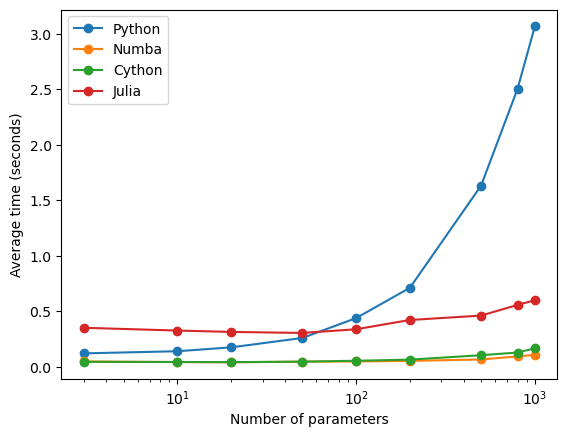

In [58]:
plt.plot(timings_py['n_dim'].values, timings_py['avg_time'].values, label='Python', marker='o')
plt.plot(timings_numba['n_dim'].values, timings_numba['avg_time'].values, label='Numba', marker='o')
plt.plot(timings_cython['n_dim'].values, timings_cython['avg_time'].values, label='Cython', marker='o')
plt.plot(timings_julia['n_dim'].values, timings_julia['avg_time'].values, label='Julia', marker='o')
plt.xlabel("Number of parameters")
plt.ylabel("Average time (seconds)")
plt.legend(loc=0)
plt.xscale('log')
plt.show()

### Relative speedup

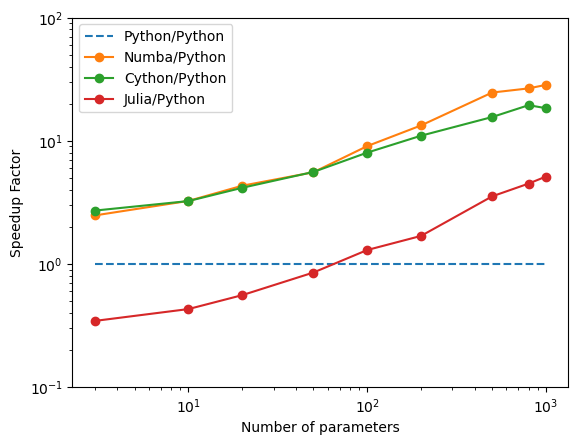

In [53]:
py_o_py = timings_py['avg_time'].values/timings_py['avg_time'].values
plt.plot(timings_py['n_dim'].values, py_o_py, label='Python/Python', linestyle='--')
py_o_n = timings_py['avg_time'].values/timings_numba['avg_time'].values
plt.plot(timings_py['n_dim'].values, py_o_n, label='Numba/Python', marker='o')
py_o_c = timings_py['avg_time'].values/timings_cython['avg_time'].values
plt.plot(timings_numba['n_dim'].values, py_o_c, label='Cython/Python', marker='o')
py_o_j = timings_py['avg_time'].values/timings_julia['avg_time'].values
plt.plot(timings_py['n_dim'].values, py_o_j, label='Julia/Python', marker='o')
# c_o_n = timings_cython['avg_time'].values/timings_numba['avg_time'].values
# plt.plot(timings_cython['n_dim'].values, c_o_n, label='Numba/Cython')
plt.xlabel("Number of parameters")
plt.ylabel("Speedup Factor")
plt.legend(loc=0)
plt.ylim((0.1,100))
plt.yscale('log')
plt.xscale('log')
plt.show()

### Summary/Discussion

The Numba and Cython versions exhibit similar performance, with the Numba version just edging out the Cython one for larger numbers of parameters (>100). Both outperform the the Python-only implementation by roughly 2-30x across the sampled numbers of parameters for this benchmark case, with bigger gains at larger numbers of parameters. These results are consistent with results I collected a few years ago on a different machine and with a different benchmark problem: [gao_implementation_scaling_comparison.ipynb](https://github.com/blakeaw/galibrate_performance_comparison/blob/master/gao_implementation_scaling_comparison.ipynb) 

The newest version which ports key functions to Julia also outperforms the Python version, but only when the number of parameters is large (roughly >=100). Presumably, the Julia functions incur some added overhead for the type inference and translation of data types between Python and Julia that contributes to loss of performance at smaller numbers of parameters. Regardless, the roughly 4-5x speedup at the largest number of parameters sampled is still a notable improvement over the Python version. However, the Numba and Cython versions still offer the best performance.    



------

## Scaling with population size

Now let's examine the scaling with the population size while holding the number of parameters and number of generations fixed.

In [33]:
# Define the parameters for the GAO.
# We'll fix the number of parameters at 100:
ndim = 100
# And the number of generations also to 100:
generations = 100
# Here, we are scaling the population size.
# We'll consider a population size up to 10000,
# which in this case is up 100x the number of parameters.
popsizes = list([8, 48, 100, 200, 500, 1000, 10000])

In [34]:
def scaling_population(popsizes, version=None, ndim=100, generations=100):
    if version is not None:
        gao.run_gao = version
    timings = dict()
    timings['pop_size'] = list()
    timings['avg_time'] = list()
    timings['std_dev'] = list()
    # Loop over the population sizes
    for ps in popsizes:
        print("Doing popsize: ", ps)
        timings['pop_size'].append(ps)
        sampled_parameters = [SampledParameter(name=i, loc=-100.0, width=200.0) for i in range(ndim)]
        go = gao.GAO(sampled_parameters, fitness, ps, generations=generations)
        #print(ndim, popsize, gen)
        ti = %timeit -n 10 -r 2 -o -q go.run()
        timings['avg_time'].append(ti.average)
        timings['std_dev'].append(ti.stdev)
        print(ti)
    timings = pd.DataFrame(timings)
    return timings

In [35]:
timings_py_pop = scaling_population(popsizes, version=run_gao_py, ndim=ndim, generations=generations)
timings_py_pop

Doing popsize:  8
50.4 ms ± 703 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing popsize:  48
196 ms ± 503 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing popsize:  100
438 ms ± 32 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing popsize:  200
830 ms ± 21.1 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing popsize:  500
1.96 s ± 23.6 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing popsize:  1000
3.99 s ± 62.1 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing popsize:  10000
40.9 s ± 70.7 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)


,pop_size,avg_time,std_dev
0,8,0.050438,0.000703
1,48,0.196262,0.000503
2,100,0.438162,0.031981
3,200,0.830432,0.021143
4,500,1.963161,0.023637
5,1000,3.994753,0.062105
6,10000,40.864540,0.070684


In [36]:
timings_numba_pop = scaling_population(popsizes, version=run_gao_numba, ndim=ndim, generations=generations)
timings_numba_pop

Doing popsize:  8
13.1 ms ± 98.7 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing popsize:  48
32.3 ms ± 3.63 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing popsize:  100
58 ms ± 900 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing popsize:  200
123 ms ± 4.34 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing popsize:  500
208 ms ± 8.56 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing popsize:  1000
414 ms ± 14.5 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing popsize:  10000
4.27 s ± 43.5 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)


,pop_size,avg_time,std_dev
0,8,0.013127,0.000099
1,48,0.032316,0.003629
2,100,0.057962,0.000900
3,200,0.123138,0.004339
4,500,0.208480,0.008564
5,1000,0.413525,0.014509
6,10000,4.272179,0.043517


In [37]:
timings_cython_pop = scaling_population(popsizes, version=run_gao_cython, ndim=ndim, generations=generations)
timings_cython_pop

Doing popsize:  8
12.7 ms ± 1.54 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing popsize:  48
38.5 ms ± 151 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing popsize:  100
60.7 ms ± 1.42 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing popsize:  200
118 ms ± 775 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing popsize:  500
279 ms ± 993 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing popsize:  1000
579 ms ± 59.2 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing popsize:  10000
5.72 s ± 51 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)


,pop_size,avg_time,std_dev
0,8,0.012695,0.001539
1,48,0.038504,0.000151
2,100,0.060670,0.001420
3,200,0.118443,0.000775
4,500,0.279283,0.000993
5,1000,0.579013,0.059193
6,10000,5.721115,0.050956


In [38]:
timings_julia_pop = scaling_population(popsizes, version=run_gao_julia, ndim=ndim, generations=generations)
timings_julia_pop

Doing popsize:  8
269 ms ± 1.2 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing popsize:  48
288 ms ± 3.2 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing popsize:  100
352 ms ± 21.8 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing popsize:  200
451 ms ± 23.4 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing popsize:  500
682 ms ± 13.2 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing popsize:  1000
1.15 s ± 66.2 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing popsize:  10000
9.44 s ± 192 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)


,pop_size,avg_time,std_dev
0,8,0.269165,0.001201
1,48,0.288260,0.003200
2,100,0.351955,0.021752
3,200,0.451238,0.023399
4,500,0.681945,0.013154
5,1000,1.147224,0.066170
6,10000,9.438376,0.192466


### Timings

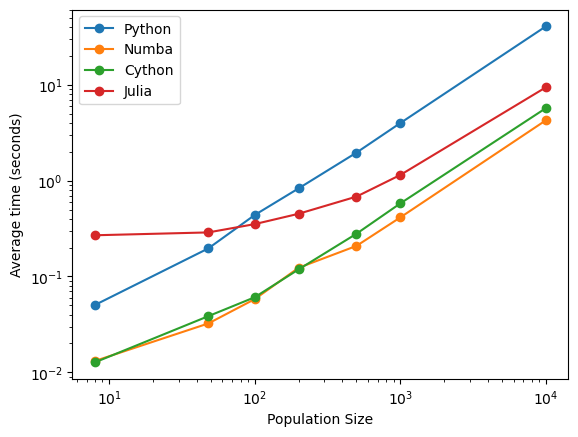

In [62]:
plt.plot(timings_py_pop['pop_size'].values, timings_py_pop['avg_time'].values, label='Python', marker='o')
plt.plot(timings_numba_pop['pop_size'].values, timings_numba_pop['avg_time'].values, label='Numba', marker='o')
plt.plot(timings_cython_pop['pop_size'].values, timings_cython_pop['avg_time'].values, label='Cython', marker='o')
plt.plot(timings_julia_pop['pop_size'].values, timings_julia_pop['avg_time'].values, label='Julia', marker='o')
plt.xlabel("Population Size")
plt.ylabel("Average time (seconds)")
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=0)
plt.show()

### Relative speedup

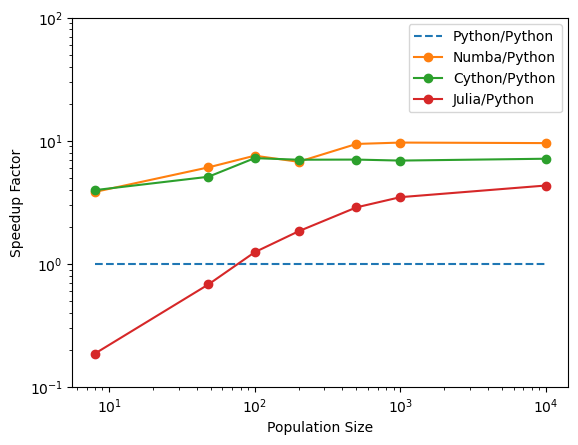

In [56]:
py_o_py = timings_py_pop['avg_time'].values/timings_py_pop['avg_time'].values
plt.plot(timings_py_pop['pop_size'].values, py_o_py, label='Python/Python', linestyle='--')
py_o_n = timings_py_pop['avg_time'].values/timings_numba_pop['avg_time'].values
plt.plot(timings_py_pop['pop_size'].values, py_o_n, label='Numba/Python', marker='o')
py_o_c = timings_py_pop['avg_time'].values/timings_cython_pop['avg_time'].values
plt.plot(timings_numba_pop['pop_size'].values, py_o_c, label='Cython/Python', marker='o')
py_o_j = timings_py_pop['avg_time'].values/timings_julia_pop['avg_time'].values
plt.plot(timings_py_pop['pop_size'].values, py_o_j, label='Julia/Python', marker='o')
plt.xlabel("Population Size")
plt.ylabel("Speedup Factor")
plt.ylim((0.1,100))
plt.yscale('log')
plt.xscale('log')
plt.legend(loc=0)
plt.show()

### Summary/Discussion

As with scaling the number of parameters, the Numba and Cython versions exhibit the best performance in all cases. Here too they have similar performance, with the Numba version just edging out the Cython one for larger population sizes (>=500). In this case, both outperform the Python-only implementation by roughly 3-10x across the sampled population sizes for this benchmark case, with bigger gains at larger population sizes. Again, pretty comparable with results I collected a few years ago on a different machine and with a different benchmark problem: [gao_implementation_scaling_comparison.ipynb](https://github.com/blakeaw/galibrate_performance_comparison/blob/master/gao_implementation_scaling_comparison.ipynb) 

Here, the Julia version outperforms the Python version when the population size is >=100 and achieves a maximum gain of roughly 3x. Below that range of population size, the added overhead of calling the Julia functions again leads to a relative loss of performance. 

------

## Scaling with the number of generations

Finally, let's examine the scaling with the number of generations while holding the number of parameters and population size fixed.

In [44]:
# Define the parameters for the GAO.
# We'll fix the number of parameters at 100:
ndim = 100
# And the population size to 1000 (10x ndim):
popsize = 1000
# Here, we are scaling the number of generations.
# We'll consider up to 200 generations.
ngenerations = list([10, 50, 100, 200])

In [45]:
def scaling_generations(ngenerations, version=None, ndim=100, popsize=100):
    if version is not None:
        gao.run_gao = version
    timings = dict()
    timings['n_generations'] = list()
    timings['avg_time'] = list()
    timings['std_dev'] = list()
    # Loop over the dimensionality (number of parameters)
    for ngen in ngenerations:
        print("Doing ngenerations: ", ngen)
        timings['n_generations'].append(ngen)
        sampled_parameters = [SampledParameter(name=i, loc=-100.0, width=200.0) for i in range(ndim)]
        go = gao.GAO(sampled_parameters, fitness, popsize, generations=ngen)
        #print(ndim, popsize, gen)
        ti = %timeit -n 10 -r 2 -o -q go.run()
        timings['avg_time'].append(ti.average)
        timings['std_dev'].append(ti.stdev)
        print(ti)
    timings = pd.DataFrame(timings)
    return timings

In [46]:
timings_py_gen = scaling_generations(ngenerations, version=run_gao_py, ndim=ndim, popsize=popsize)
timings_py_gen

Doing ngenerations:  10
330 ms ± 476 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ngenerations:  50
1.45 s ± 14.5 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ngenerations:  100
2.83 s ± 14.6 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ngenerations:  200
5.6 s ± 11.4 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)


,n_generations,avg_time,std_dev
0,10,0.330030,0.000476
1,50,1.447979,0.014463
2,100,2.832689,0.014581
3,200,5.601019,0.011418


In [47]:
timings_numba_gen = scaling_generations(ngenerations, version=run_gao_numba, ndim=ndim, popsize=popsize)
timings_numba_gen

Doing ngenerations:  10
32.2 ms ± 503 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ngenerations:  50
134 ms ± 1.4 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ngenerations:  100
265 ms ± 4.88 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ngenerations:  200
528 ms ± 1.73 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)


,n_generations,avg_time,std_dev
0,10,0.032223,0.000503
1,50,0.134498,0.001400
2,100,0.265397,0.004878
3,200,0.527726,0.001735


In [48]:
timings_cython_gen = scaling_generations(ngenerations, version=run_gao_cython, ndim=ndim, popsize=popsize)
timings_cython_gen

Doing ngenerations:  10
43.2 ms ± 244 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ngenerations:  50
181 ms ± 730 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ngenerations:  100
360 ms ± 10.4 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ngenerations:  200
695 ms ± 5.93 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)


,n_generations,avg_time,std_dev
0,10,0.043196,0.000244
1,50,0.181007,0.000730
2,100,0.360353,0.010384
3,200,0.695183,0.005932


In [49]:
timings_julia_gen = scaling_generations(ngenerations, version=run_gao_julia, ndim=ndim, popsize=popsize)
timings_julia_gen

Doing ngenerations:  10
91.7 ms ± 11.7 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ngenerations:  50
369 ms ± 4.97 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ngenerations:  100
692 ms ± 931 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
Doing ngenerations:  200
1.45 s ± 32.7 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)


,n_generations,avg_time,std_dev
0,10,0.091718,0.011711
1,50,0.368789,0.004966
2,100,0.692280,0.000931
3,200,1.450889,0.032674


### Timings

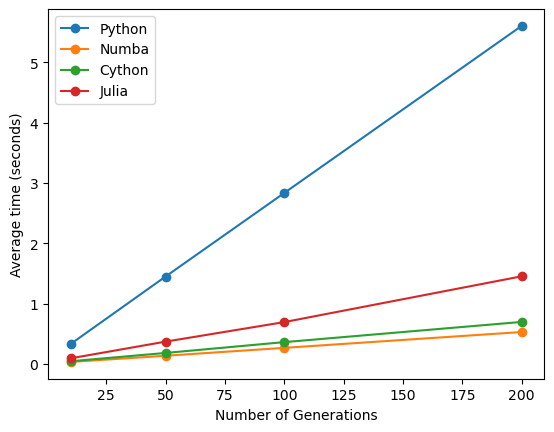

In [59]:
plt.plot(timings_py_gen['n_generations'].values, timings_py_gen['avg_time'].values, label='Python', marker='o')
plt.plot(timings_numba_gen['n_generations'].values, timings_numba_gen['avg_time'].values, label='Numba', marker='o')
plt.plot(timings_cython_gen['n_generations'].values, timings_cython_gen['avg_time'].values, label='Cython', marker='o')
plt.plot(timings_julia_gen['n_generations'].values, timings_julia_gen['avg_time'].values, label='Julia', marker='o')
plt.xlabel("Number of Generations")
plt.ylabel("Average time (seconds)")
plt.legend(loc=0)
plt.show()

### Relative speedup

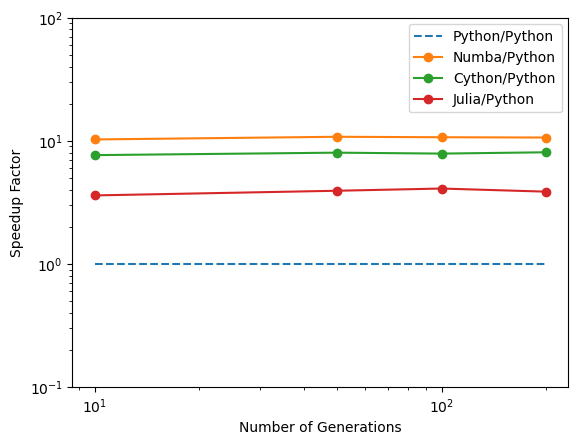

In [60]:
py_o_py = timings_py_gen['avg_time'].values/timings_py_gen['avg_time'].values
plt.plot(timings_py_gen['n_generations'].values, py_o_py, label='Python/Python', linestyle='--')
py_o_n = timings_py_gen['avg_time'].values/timings_numba_gen['avg_time'].values
plt.plot(timings_py_gen['n_generations'].values, py_o_n, label='Numba/Python', marker='o')
py_o_c = timings_py_gen['avg_time'].values/timings_cython_gen['avg_time'].values
plt.plot(timings_numba_gen['n_generations'].values, py_o_c, label='Cython/Python', marker='o')
py_o_j = timings_py_gen['avg_time'].values/timings_julia_gen['avg_time'].values
plt.plot(timings_py_gen['n_generations'].values, py_o_j, label='Julia/Python', marker='o')
plt.xlabel("Number of Generations")
plt.ylabel("Speedup Factor")
plt.ylim((0.1,100))
plt.yscale('log')
plt.xscale('log')
plt.legend(loc=0)
plt.legend(loc=0)
plt.show()

### Summary/Discussion

Alhtough the total time increases with number of generations, the relative performance isn't really affected by the number of generations. In this case, the relative performance increases are consistently around 10x, 8x, and 3x for the Numba, Cython, and Julia implementations, respectively. As in the other scaling cases, we can see that the Numba and Cython versions perform the best, but the Julia version still has a notable performance increase over the Python version.  


------
------

## Summary and Closing Thoughts

The analysis here shows that the Numba, Cython, and Julia versions of the GAO can have significantly greater performance than the Python-only version, particularly for large problems (large numbers of parameters and/or population sizes). The Numba and Cython version have comparable performance with the Numba version just mildly outperforming the Cython one for large problems. The Julia version only sees improvement for large problem sizes, with the added overhead of converting data between Pyton and Julia slowing things down some when the numbers of parameters and/or population sizes are small.  

In all, the accelearated vesions using Numba, Cython, or Julia can yield relative performance enhancements of anywhere from about 2-30 fold speed increase over the Python-only version depending on the number of model parameters (dimensionality) and choice of GA population size.  

In our previous analysis with a different test case (different model and fitness function) we got pretty comparable results in comparing the Python, Numba, and Cython versions: [gao_implementation_scaling_comparison.ipynb](https://github.com/blakeaw/galibrate_performance_comparison/blob/master/gao_implementation_scaling_comparison.ipynb). 

Based on profiling data, evaluating the fitness function tends to be the major bottleneck. When using the Numba version, it may be possible to JIT the fitness function as well to further improve performance. I may test this further in the future. Also, as of GAlibrate version 0.5.0, the GAO can use multiprocessing-based parallelism when evaluating the fitness function. It would be interesting to more rigorously benchmark the parallel performnace and identify when it may be most helpful. I'm also considering if it may be worth implementing GPU offloading with Numba and its ability to compile CUDA kernels.  